<a href="https://colab.research.google.com/github/MinhQuan2211/AI-Final-Project/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STEP 1 : Load libraries**

In [34]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import pandas as pd #Data manipulation and analysis
import numpy as np  #It is utilised a number of mathematical operations
import seaborn as sns  #visualization
import matplotlib.pyplot as plt #plotting library
from datetime import datetime 
import statsmodels.api as sm #Conducting statistical tests
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm #Statistical library

**STEP 2 : Importing dataset**

In [36]:
df = pd.read_csv('Data.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100990 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [38]:
df.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

**STEP 3 : Pre-processing and EDA(exploratory data analysis)**

Text(0, 0.5, 'features')

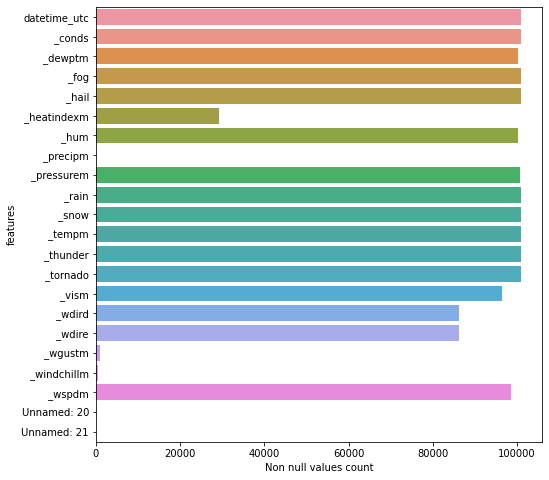

In [39]:
# Looking for the missing values
plt.figure(figsize=(8,8))
sns.barplot(x = df.count()[:],y = df.count().index)
plt.xlabel('Non null values count')
plt.ylabel('features')

In [40]:
# There are missing values in every column so now we are going to consider only a few of the columns which seem important for our basic EDA
df = df.drop([' _dewptm',' _fog',' _hail',' _heatindexm',' _pressurem',' _precipm',' _rain',' _snow',' _thunder',' _tornado',' _vism',' _wdird',' _wdire',' _wgustm',' _windchillm',' _wspdm'],axis=1)

In [41]:
df.head()

,datetime_utc,_conds,_hum,_tempm,Unnamed: 20,Unnamed: 21
0,19961101-11:00,Smoke,27.0,27.819111,NaN,NaN
1,19961101-12:00,Smoke,32.0,29.449021,NaN,NaN
2,19961101-13:00,Smoke,44.0,30.279879,NaN,30.39197
3,19961101-14:00,Smoke,41.0,33.323214,NaN,NaN
4,19961101-16:00,Smoke,47.0,29.787564,NaN,NaN


In [42]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))
df['datetime_utc'].head()

0   1996-11-01 11:00:00
1   1996-11-01 12:00:00
2   1996-11-01 13:00:00
3   1996-11-01 14:00:00
4   1996-11-01 16:00:00
Name: datetime_utc, dtype: datetime64[ns]

In [43]:
# as we can see on the above table datatime_utc is column so we have to convert this to index
df = df.set_index('datetime_utc',drop = True)
df.index.name = 'datetime'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100990 entries, 1996-11-01 11:00:00 to 2017-04-24 18:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0    _conds      100918 non-null  object 
 1    _hum        100233 non-null  float64
 2    _tempm      100990 non-null  float64
 3   Unnamed: 20  0 non-null       float64
 4   Unnamed: 21  1 non-null       float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [44]:
df = df.rename(index = str, columns={' _conds':'condition',' _hum':'humidity',' _tempm':'temperature'})
df.head()

,condition,humidity,temperature,Unnamed: 20,Unnamed: 21
datetime,,,,,
1996-11-01 11:00:00,Smoke,27.0,27.819111,NaN,NaN
1996-11-01 12:00:00,Smoke,32.0,29.449021,NaN,NaN
1996-11-01 13:00:00,Smoke,44.0,30.279879,NaN,30.39197
1996-11-01 14:00:00,Smoke,41.0,33.323214,NaN,NaN
1996-11-01 16:00:00,Smoke,47.0,29.787564,NaN,NaN


In [45]:
df.isnull().sum()

condition          72
humidity          757
temperature         0
Unnamed: 20    100990
Unnamed: 21    100989
dtype: int64

In [46]:
df.fillna(df.mean(), inplace=True)
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


condition          72
humidity            0
temperature         0
Unnamed: 20    100990
Unnamed: 21         0
dtype: int64

In [47]:
df.ffill(inplace=True)
df[df.isnull()].count()

condition      0
humidity       0
temperature    0
Unnamed: 20    0
Unnamed: 21    0
dtype: int64

Text(0, 0.5, 'Percent')

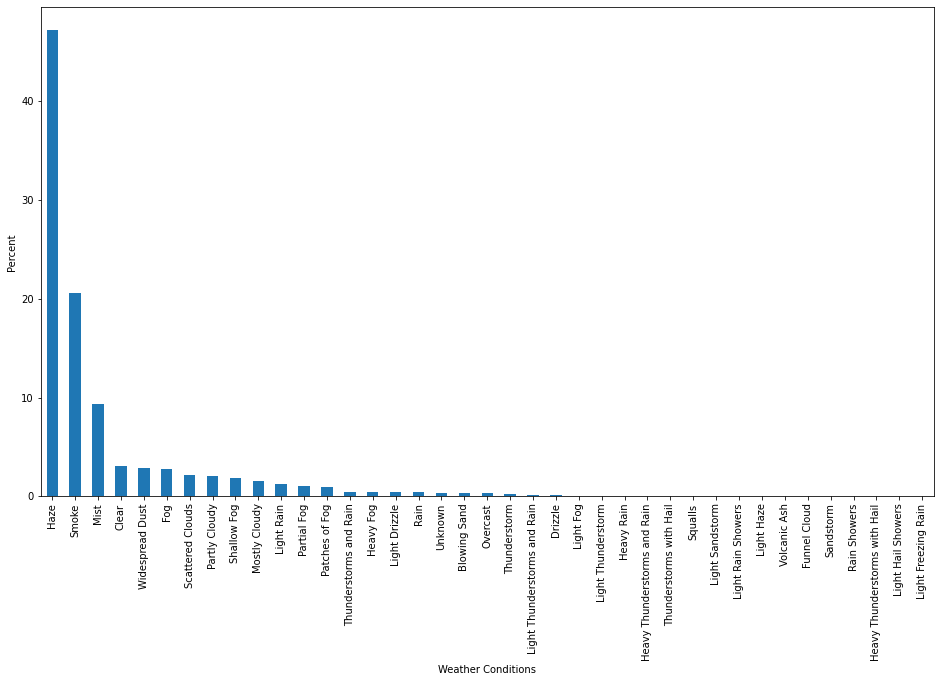

In [48]:
weather_condition   = (df.condition.value_counts()/(df.condition.value_counts().sum())) * 100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

In [49]:
df.index = pd.to_datetime(df.index)
df = df.resample('H').mean().interpolate()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179504 entries, 1996-11-01 11:00:00 to 2017-04-24 18:00:00
Freq: H
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   humidity     179504 non-null  float64
 1   temperature  179504 non-null  float64
 2   Unnamed: 20  0 non-null       float64
 3   Unnamed: 21  179504 non-null  float64
dtypes: float64(4)
memory usage: 6.8 MB


In [50]:
df.describe()

,humidity,temperature,Unnamed: 20,Unnamed: 21
count,179504.000000,179504.000000,0.0,1.795040e+05
mean,58.425165,30.495092,NaN,3.039197e+01
std,23.465756,2.761463,NaN,1.776312e-14
min,4.000000,21.000000,NaN,3.039197e+01
25%,40.000000,28.310337,NaN,3.039197e+01
50%,59.000000,30.517321,NaN,3.039197e+01
75%,78.000000,32.643256,NaN,3.039197e+01
max,243.000000,37.000000,NaN,3.039197e+01


In [51]:
df = df[df.temperature < 50]
df = df[df.humidity <= 100]

df.describe()

,humidity,temperature,Unnamed: 20,Unnamed: 21
count,179495.000000,179495.000000,0.0,1.794950e+05
mean,58.420343,30.495022,NaN,3.039197e+01
std,23.453945,2.761498,NaN,1.421041e-14
min,4.000000,21.000000,NaN,3.039197e+01
25%,40.000000,28.310207,NaN,3.039197e+01
50%,59.000000,30.517225,NaN,3.039197e+01
75%,78.000000,32.643233,NaN,3.039197e+01
max,100.000000,37.000000,NaN,3.039197e+01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d56bc6650>,
      dtype=object)

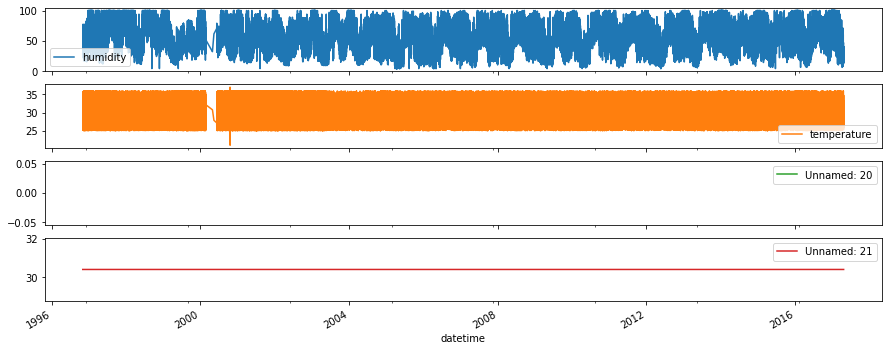

In [52]:
df.plot(subplots = True , figsize= (15,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d5236a510>,
      dtype=object)

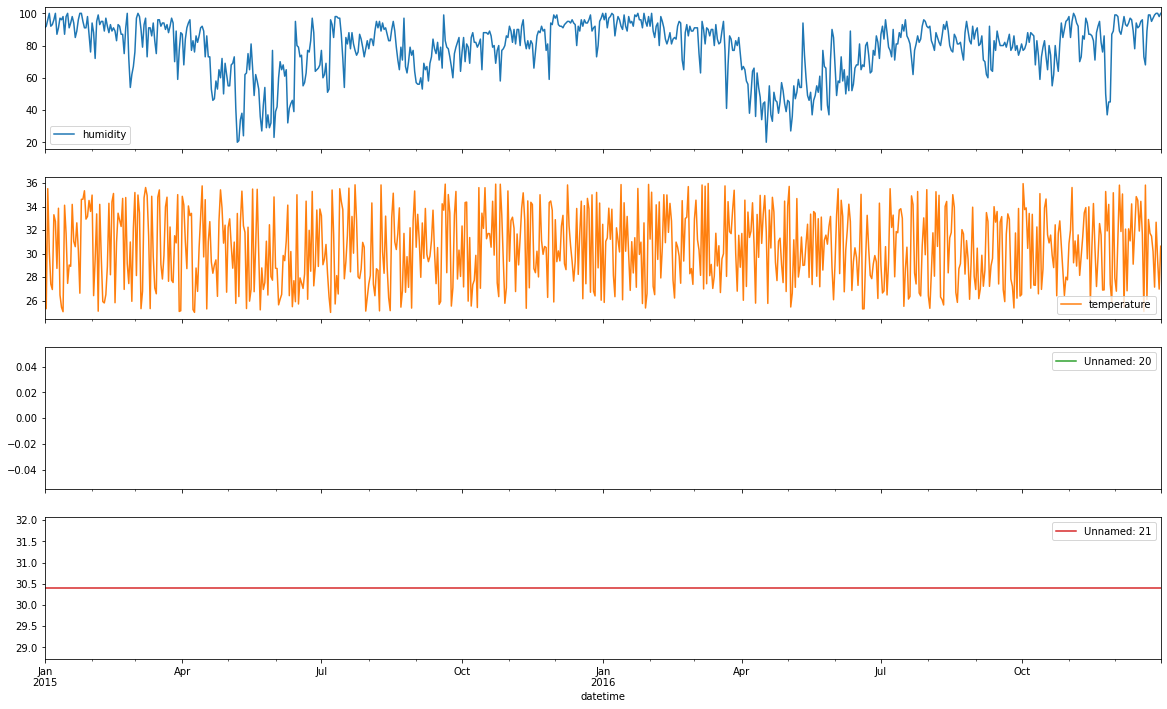

In [53]:
df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

**STEP 4 : Model building**

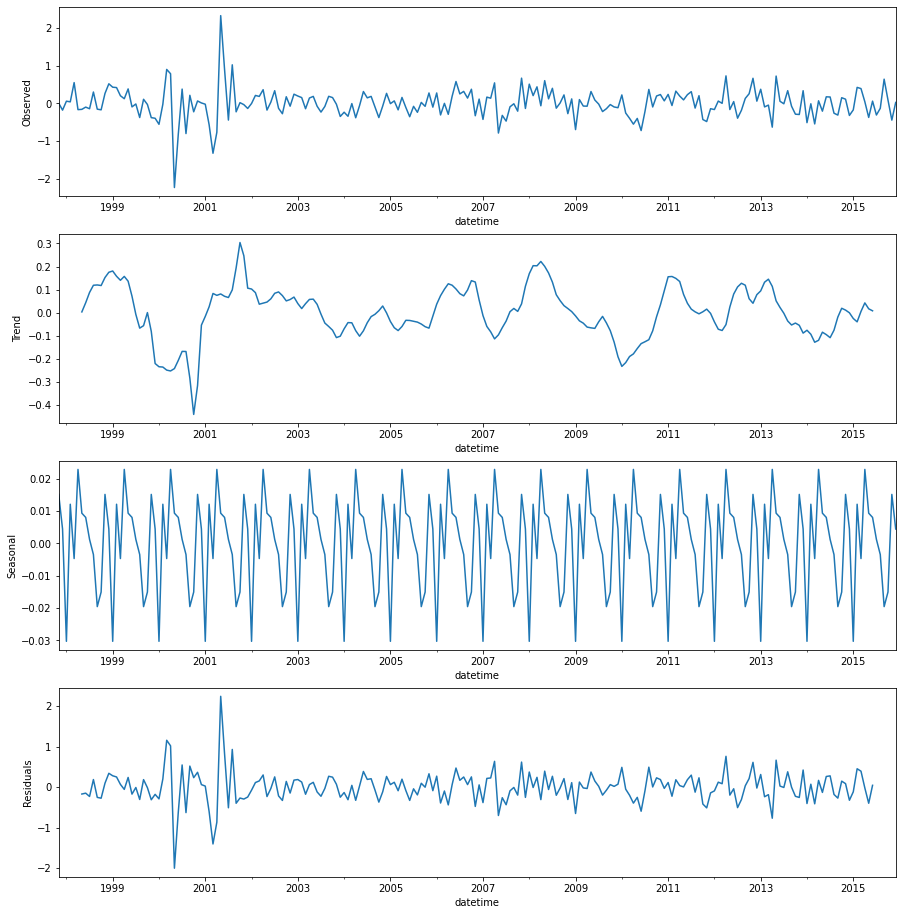

In [54]:
train = df[:'2015']
test = df['2016':]

def decomposeNplot(data):
  decomposition = sm.tsa.seasonal_decompose(data)

  plt.figure(figsize=(15,16))

  ax1 = plt.subplot(411)
  decomposition.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')

  ax2 = plt.subplot(412)
  decomposition.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')

  ax3 = plt.subplot(413)
  decomposition.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')

  ax4 = plt.subplot(414)
  decomposition.resid.plot(ax=ax4)
  ax4.set_ylabel('Residuals')

  return decomposition

# Resampling the data to mothly and averaging out the temperature & we will predict the monthly average temperature
ftraindata = train['temperature'].resample('M').mean()
ftestdata = test['temperature'].resample('M').mean()

# Taking the seasonal difference S=12 and decomposing the timeseries
decomposition = decomposeNplot(ftraindata.diff(12).dropna())

In [55]:
results = adfuller(ftraindata.diff(12).dropna())
results

(-6.56467428026453,
 8.215585384523407e-09,
 11,
 206,
 {'1%': -3.4624988216864776,
  '10%': -2.5743041549627677,
  '5%': -2.8756749365852587},
 160.61308458617412)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


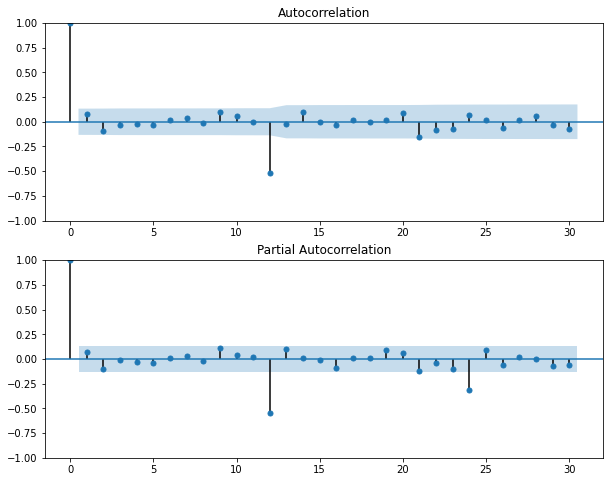

In [56]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=30,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=30,ax=ax2)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


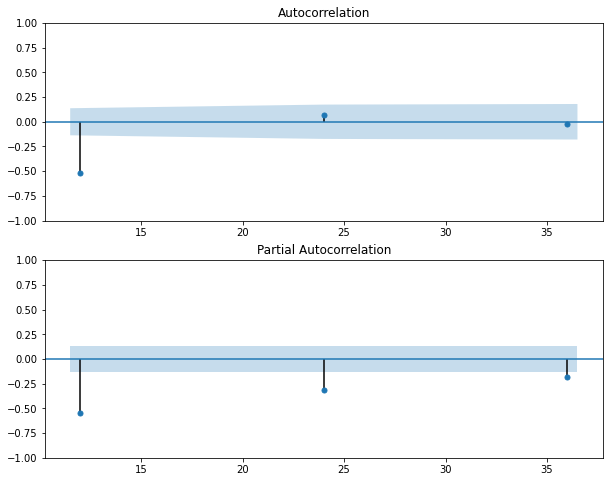

In [57]:
lags = [12*i for i in range(1,4)]

plt.figure(figsize=(10,8))

ax1 = plt.subplot(211)
acf = plot_acf(ftraindata.diff(12).dropna(),lags=lags,ax=ax1)

ax2 = plt.subplot(212)
pacf = plot_pacf(ftraindata.diff(12).dropna(),lags=lags,ax=ax2)

In [58]:
results = pm.auto_arima(ftraindata,seasonal=True, m=12,d=0,D=1,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=222.595, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=155.200, Time=1.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=220.597, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=223.373, Time=0.24 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=136.663, Time=5.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=138.026, Time=2.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=136.587, Time=2.30 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=156.335, Time=0.77 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=138.504, Time=

In [59]:
mod = sm.tsa.statespace.SARIMAX(ftraindata,
                                order=(3, 0, 3),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                  230
Model:             SARIMAX(3, 0, 3)x(1, 1, [1], 12)   Log Likelihood                 -42.097
Date:                              Tue, 21 Jun 2022   AIC                            102.194
Time:                                      12:12:36   BIC                            131.968
Sample:                                  11-30-1996   HQIC                           114.241
                                       - 12-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3120      2.818      0.111      0.912      -5.210       5.834
ar.L2          0.16

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


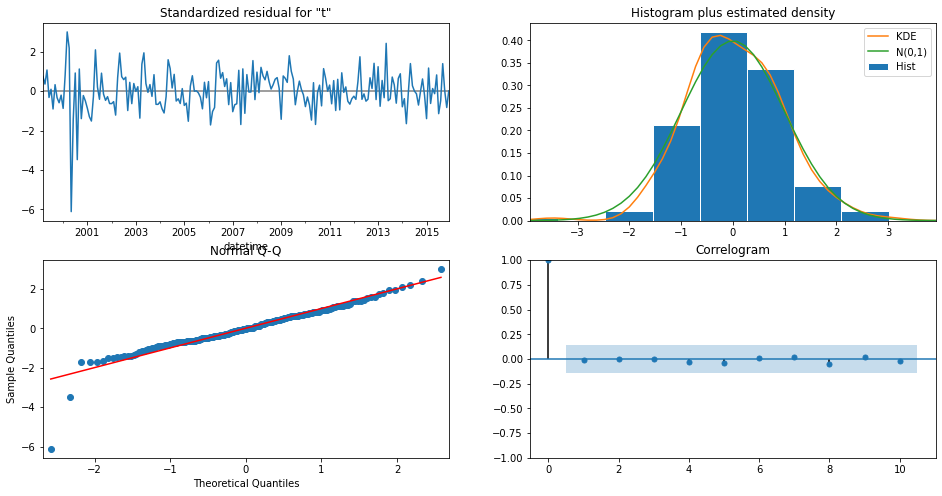

In [60]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [61]:
print(np.mean(np.abs(results.resid)))

1.5801311926917063


**STEP 5 : Forecasting**

In [62]:
forecast = results.get_forecast(steps=len(ftestdata))

In [63]:
predictedmean = forecast.predicted_mean
bounds = forecast.conf_int()
lower_limit = bounds.iloc[:,0]
upper_limit = bounds.iloc[:,1]

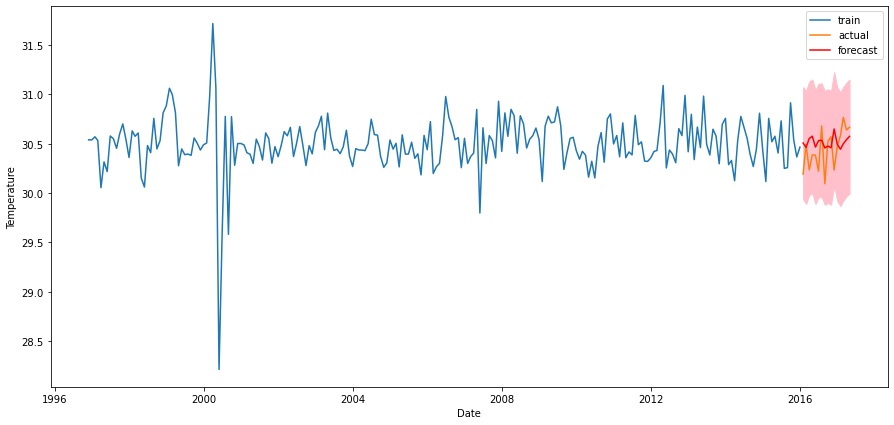

In [64]:
plt.figure(figsize=(15,7))

plt.plot(ftraindata.index, ftraindata, label='train')
plt.plot(ftestdata.index,ftestdata,label='actual')

plt.plot(predictedmean.index, predictedmean, color='r', label='forecast')

plt.fill_between(lower_limit.index,lower_limit,upper_limit, color='pink')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

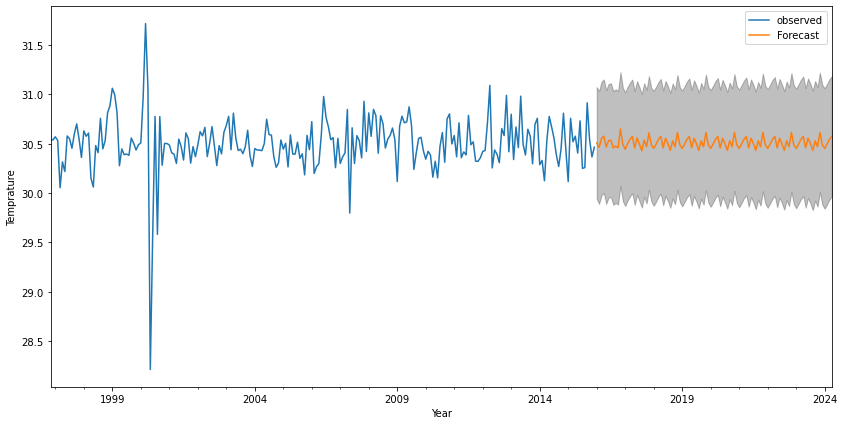

In [67]:
#Producing and visualizing forecast

pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ftraindata.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temprature')
plt.legend()
plt.show()

**STEP 6 : Saving the model for future reference**

In [66]:
import joblib

joblib.dump(forecast,'finalized_model.pkl')

['finalized_model.pkl']